

We will now train and tag the words using the features extracted from Word2Vec in the previous step.

In [1]:
#Linear Chain CRF
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#Loading the word features and labels
X = np.load("kannada-features.numpy").astype(np.float32)
Y = np.load("kannada-labels.numpy").astype(np.int32)

np.random.seed(546)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

In [3]:
#Sequence Length
num_examples, num_words, num_features = X.shape
num_tags = np.unique(Y).size

sequence_lengths = np.full(num_examples, 0, dtype=np.int32)
for idx, row in enumerate(X):
    count = 0
    for word in row:
        if np.all(word == -1):
            break
        count += 1
    sequence_lengths[idx] = count

In [4]:
#Splitting the data into Training and Test sets
split = 100
x_test = X[-split:,:,:]
y_test = Y[-split:,:]
s_test = sequence_lengths[-split:]

x = X[0:-split,:,:]
y = Y[0:-split,:]
sequence_lengths = sequence_lengths[0:-split]

In [5]:
#Training on Linear Chain CRF
with tf.Graph().as_default():
    with tf.Session() as session:
        x_t = tf.constant(x)
        xt_t = tf.constant(x_test)
        y_t = tf.constant(y)
        yt_t = tf.constant(y_test)
        sequence_lengths_t = tf.constant(sequence_lengths)
        st_t = tf.constant(s_test)
        
        weights = tf.get_variable("weights", [num_features, num_tags])
        matricized_x_t = tf.reshape(x_t, [-1, num_features])
        matricized_unary_scores = tf.matmul(matricized_x_t, weights)
        unary_scores = tf.reshape(matricized_unary_scores, [num_examples-split, num_words, num_tags])
        
        matricized_xt_t = tf.reshape(xt_t, [-1, num_features])
        matricized_ust = tf.matmul(matricized_xt_t, weights)
        ust = tf.reshape(matricized_ust, [split, num_words, num_tags])
        
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(unary_scores, y_t, sequence_lengths_t)
        
        loss = tf.reduce_mean(-log_likelihood)
        train_op = tf.train.GradientDescentOptimizer(0.03).minimize(loss)
        
        session.run(tf.global_variables_initializer())
        for i in range(400):
            tf_ust, tf_unary_scores, tf_transition_params, _ = session.run([ust, unary_scores, transition_params, train_op])
            if i%25== 0:
                correct_labels = 0
                total_labels = 0
                for tf_unary_scores_, y_, sequence_length_ in zip(tf_unary_scores, y, sequence_lengths):
                    tf_unary_scores_ = tf_unary_scores_[:sequence_length_]
                    y_ = y_[:sequence_length_]
                    
                    viterbi_sequence, _ = tf.contrib.crf.viterbi_decode(tf_unary_scores_, tf_transition_params)
                    
                    correct_labels += np.sum(np.equal(viterbi_sequence, y_))
                    total_labels += sequence_length_
                    #print(total_labels)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print(f"Classification Accuracy (Training set): {accuracy}")
       
        
            correct_labels = 0
            total_labels = 0
            pred_labels = []
            actual_labels = []
            for a, b, c in zip(tf_ust, y_test, s_test):
                a = a[:c]
                b = b[:c]
            
                vs, _ = tf.contrib.crf.viterbi_decode(a, tf_transition_params)
                correct_labels += np.sum(np.equal(vs, b))
                total_labels += c
            
                actual_labels = actual_labels + b.tolist()
                pred_labels = pred_labels + vs
            
                accuracy = 100.0 * correct_labels / float(total_labels)
                #print "-------------------------------------------------"
        print(f"Classification Accuracy (Test set): {accuracy}")

Classification Accuracy (Training set): 3.758770464416973
Classification Accuracy (Training set): 80.22051453391246
Classification Accuracy (Training set): 83.66187771466755
Classification Accuracy (Training set): 85.06515202138323
Classification Accuracy (Training set): 85.91713999331775
Classification Accuracy (Training set): 86.83595055128633
Classification Accuracy (Training set): 87.42064817908454
Classification Accuracy (Training set): 87.85499498830605
Classification Accuracy (Training set): 88.13899097895089
Classification Accuracy (Training set): 88.52322084864684
Classification Accuracy (Training set): 88.85733377881724
Classification Accuracy (Training set): 89.1580354159706
Classification Accuracy (Training set): 89.54226528566656
Classification Accuracy (Training set): 89.85967256932844
Classification Accuracy (Training set): 90.07684597393919
Classification Accuracy (Training set): 90.26060808553291
Classification Accuracy (Test set): 80.95238095238095


In [6]:
#Model Evaluation - Classification Report
from sklearn.metrics import classification_report

target_names = np.array(['CC', 'DEM', 'IRR', 'JJ', 'NEG', 'NN', 'NST', 'PRP', 'NUM', 'QF',
       'RB', 'RP', 'SYM', 'VM', 'WQ'])


print(classification_report (actual_labels, pred_labels, target_names=target_names[np.unique(actual_labels)].tolist()))



              precision    recall  f1-score   support

          CC       1.00      1.00      1.00        14
         DEM       1.00      0.91      0.95        11
          JJ       0.71      0.49      0.58        51
         NEG       0.00      0.00      0.00         1
          NN       0.82      0.94      0.88       420
         NST       0.57      0.27      0.36        15
         PRP       0.93      0.62      0.74        21
         NUM       0.97      0.74      0.84        46
          QF       0.50      0.14      0.22         7
          RB       0.25      0.12      0.17         8
          RP       0.62      0.71      0.67         7
         SYM       0.50      0.50      0.50         2
          VM       0.69      0.60      0.64        67
          WQ       0.00      0.00      0.00         2

   micro avg       0.81      0.81      0.81       672
   macro avg       0.61      0.50      0.54       672
weighted avg       0.80      0.81      0.79       672



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 12
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 12
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white")

    plt.ylabel('Features')
    plt.xlabel('Classes')
    plt.tight_layout()
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')

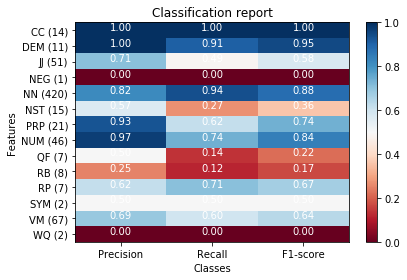

In [8]:

def main():

    sampleClassificationReport = """                         precision    recall  f1-score   support

          CC       1.00      1.00      1.00        14
         DEM       1.00      0.91      0.95        11
          JJ       0.71      0.49      0.58        51
         NEG       0.00      0.00      0.00         1
          NN       0.82      0.94      0.88       420
         NST       0.57      0.27      0.36        15
         PRP       0.93      0.62      0.74        21
         NUM       0.97      0.74      0.84        46
          QF       0.50      0.14      0.22         7
          RB       0.25      0.12      0.17         8
          RP       0.62      0.71      0.67         7
         SYM       0.50      0.50      0.50         2
          VM       0.69      0.60      0.64        67
          WQ       0.00      0.00      0.00         2"""

    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.close()
  


if __name__ == '__main__':
    main()